### Necessary imports

In [139]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

### Hyperparameters

In [140]:
sequence_length = 5
total_digits = 5
input_size = 10*total_digits
output_size = 11*(total_digits+1)
batch = 32
hidden_size = 512
num_layers = 1
num_epochs = 10000
learning_rate = 0.001

### Generate samples

In [141]:
def add_vec(x,y):
    n = max(len(x),len(y))
    return num2vec(vec2num(x)+vec2num(y),n)

def vec2num(x):
    s = 0
    for i in range(len(x)):
        if x[i] == 10:
            break    
        s *= 10
        s += x[i]
    return s

def num2vec(x, n):
    y = np.zeros(n) + 10
    digits = len(str(int(x)))
    for i in range(digits):
        y[i] = (x//10**(digits-i-1))%10
    return y

def encode_in(x):
    y = np.zeros(len(x)*10)
    for i in range(len(x)):
        if x[i] == 10:
            break
        else:
            y[10*i+int(x[i])] = 1
    return y

def encode_out(x):
    y = np.zeros(len(x)*11, dtype=int)
    for i in range(len(x)):
        if x[i] == 10:
            y[11*i+10] = 1
        else:
            y[11*i+int(x[i])] = 1
    return y

def decode_out(x):
    y = np.zeros(len(x)//11, dtype=int)
    for i in range(len(y)):
        y[i] = np.argmax(x[i*11:(i+1)*11])
    return y

def generate():
    input_dec = np.zeros((batch,sequence_length,total_digits),dtype=int) + 10
    input_enc = np.zeros((batch,sequence_length,input_size),dtype=int)
    output_dec = np.zeros((batch,sequence_length,total_digits+1),dtype=int)
    output_enc = np.zeros((batch,sequence_length,output_size),dtype=int)
    for i in range(batch):
        for j in range(sequence_length):
            digits = np.random.randint(total_digits) + 1    
            for k in range(digits):
                d = np.random.randint(10)
                input_dec[i,j,k] = d
            if j == 0:
                output_dec[i,j,:-1] = input_dec[i,j,:]
                output_dec[i,j,-1] = 10
            elif j > 0:
                output_dec[i,j,:] = add_vec(output_dec[i,j-1,:], input_dec[i,j,:])
            input_enc[i,j,:] = encode_in(input_dec[i,j,:])
            output_enc[i,j,:] = encode_out(output_dec[i,j,:])
    x = Variable(torch.from_numpy(input_enc)).float()
    y = Variable(torch.from_numpy(output_dec)).long()
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
    return x, y
    

### Neural Network

In [142]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(sequence_length*hidden_size, sequence_length*output_size)
    
    def forward(self, x):
        (h0, c0) = self.init_hidden_state()
        out, (h0, c0) = self.lstm(x, (h0, c0))
        out = out.contiguous()
        out = self.fc(out.view(batch,-1))
        for j in range(sequence_length):
            for i in range(total_digits+1):
                out[:,output_size*j + i*11:output_size*j + (i+1)*11] = \
                F.softmax(out[:,output_size*j + i*11:output_size*j + (i+1)*11].clone())
        return out
    
    def init_hidden_state(self):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size).cuda()) 
            c0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size).cuda())
        else:
            h0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size)) 
            c0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size))
        return h0, c0

rnn = RNN(input_size, hidden_size, num_layers)
if torch.cuda.is_available():
    rnn.cuda()

### Loss and optimizer

In [143]:
def CustomLoss(x,y,criterion):
    s = Variable(torch.zeros(1), requires_grad=False)
    y = y.view(batch,-1)
    for j in range(1,sequence_length):
        for i in range(total_digits+1):
            s = s + criterion(x[:,output_size*j + i*11:output_size*j + (i+1)*11],\
                              y[:,(total_digits+1)*j + i])
    return s

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [1]:
def accuracy(out,y):
    if torch.cuda.is_available():
        out = out.view(batch,sequence_length,-1).cpu().data.numpy()
        y = y.view(batch,sequence_length,-1).cpu().data.numpy()        
    else:
        out = out.view(batch,sequence_length,-1).data.numpy()
        y = y.view(batch,sequence_length,-1).data.numpy()
    s = 0.
    for k in range(batch):
        for j in range(1,sequence_length):
            dec = decode_out(out[k,j,:])
            if np.allclose(dec,y[k,j,:]):
                s += 1
    return s/((sequence_length-1)*batch)

def _exponential_moving_average_smoothing(values, smoothing_factor):
    if smoothing_factor == 0:
        return values
    if isinstance(values, list):
        values = np.array(values)
    return pandas.stats.moments.ewma(values, span=smoothing_factor)
            
    

### Train

In [145]:
losses = np.zeros(num_epochs)
acc = np.zeros(num_epochs)
last_time = time.time()
for i in range(num_epochs):
    rnn.zero_grad()
    x,y = generate()
    out = rnn(x)
    acc[i] = accuracy(out,y)
    loss = CustomLoss(out,y,criterion)
    losses[i] = loss.data[0]
    loss.backward()
    optimizer.step()
    if (i+1)%(num_epochs//20) == 0:
        print('Step '+ str(i+1) + '/' +str(num_epochs)+ ' done. Loss = ' + \
              str(losses[i])+ '. Accuracy = ' + str(acc[i]) + '. Time elapsed: ' + str(time.time()-last_time))
        last_time = time.time()
        

Step 500/10000 done. Loss = 52.8465232849. Accuracy = 0.0. Time elapsed: 29.285609006881714
Step 1000/10000 done. Loss = 50.8768424988. Accuracy = 0.0078125. Time elapsed: 29.1622371673584
Step 1500/10000 done. Loss = 50.0215797424. Accuracy = 0.015625. Time elapsed: 29.135515213012695
Step 2000/10000 done. Loss = 50.2276573181. Accuracy = 0.0078125. Time elapsed: 29.166528940200806
Step 2500/10000 done. Loss = 49.2199821472. Accuracy = 0.0. Time elapsed: 29.127482891082764
Step 3000/10000 done. Loss = 48.4161643982. Accuracy = 0.0. Time elapsed: 29.031235933303833
Step 3500/10000 done. Loss = 48.9818840027. Accuracy = 0.0234375. Time elapsed: 28.92485809326172
Step 4000/10000 done. Loss = 49.5479736328. Accuracy = 0.0078125. Time elapsed: 28.84979796409607
Step 4500/10000 done. Loss = 49.0483856201. Accuracy = 0.0. Time elapsed: 28.84592580795288
Step 5000/10000 done. Loss = 48.2152137756. Accuracy = 0.0078125. Time elapsed: 28.867809772491455
Step 5500/10000 done. Loss = 50.123329162

### Plots

/Users/daspy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version


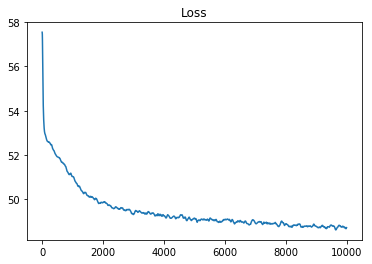

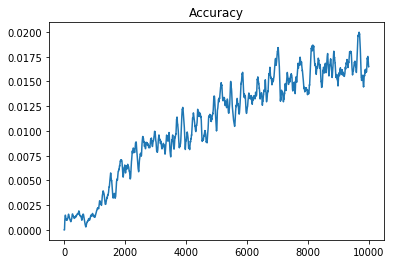

In [148]:
%matplotlib inline
losses_f = _exponential_moving_average_smoothing(losses, 50)
plt.plot(losses_f)
plt.title('Loss')
plt.figure()
acc_f = _exponential_moving_average_smoothing(acc, 50)
plt.plot(acc_f)
plt.title('Accuracy')